# sentiment analysis

Gradient descent (GD) for logistic regression is given by

$$ \theta_j = \theta_j - \alpha \frac{\partial}{\partial \theta_j} J(\theta) $$

where $\alpha$ is the learning rate and $J(\theta)$ is the cost function. 

The cost function for logistic regression is given by

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log(h_\theta(x^{(i)})) - (1 - y^{(i)}) \log(1 - h_\theta(x^{(i)})) \right] $$

sigmoid function 
$$h_\theta(x^{(i)}) = \frac{1}{1 + e^{-\theta^T x^{(i)}}}$$




In [5]:
import nltk                                  # Python library for NLP
from nltk.corpus import twitter_samples      # sample Twitter dataset from NLTK
import matplotlib.pyplot as plt              # visualization library
import numpy as np                           # library for scientific computing and matrix operations
import re 
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import string 
import random
nltk.download('twitter_samples')
nltk.download('stopwords')


[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/admin/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Number of tweets:  10000
#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
hopeless for tmr :(

[['happi', 212, 25], ['merri', 1, 0], ['nice', 99, 19], ['good', 238, 101], ['bad', 18, 73], ['sad', 5, 123], ['mad', 4, 11], ['best', 65, 22], ['pretti', 20, 15], ['❤️', 0, 0], [':)', 3691, 2], [':(', 1, 4584], ['😒', 2, 3], ['😬', 0, 2], ['😄', 5, 1], ['😍', 5, 1], ['♛', 0, 210], ['song', 22, 27], ['idea', 27, 10], ['power', 7, 6], ['play', 46, 48], ['magnific', 2, 0]]


/Users/admin/anaconda3/envs/ml_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


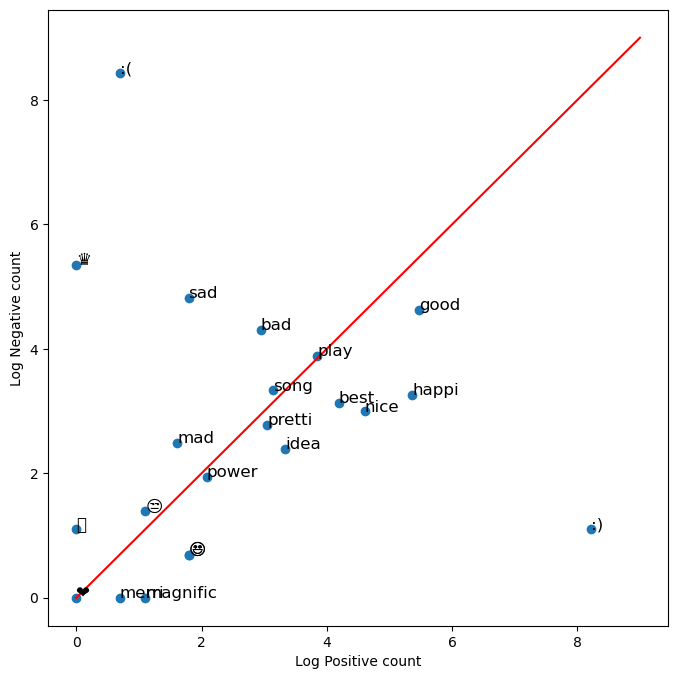

In [6]:


def load_tweets():
    all_positive_tweets = twitter_samples.strings('positive_tweets.json')
    all_negative_tweets = twitter_samples.strings('negative_tweets.json')  
    return all_positive_tweets, all_negative_tweets

# select the lists of positive and negative tweets
all_positive_tweets,all_negative_tweets = load_tweets()

# concatenate the lists, 1st part is the positive tweets followed by the negative
tweets = all_positive_tweets + all_negative_tweets

# let's see how many tweets we have
print("Number of tweets: ", len(tweets))
print(all_positive_tweets[0])
print(all_negative_tweets[0])
print()
labels = np.append(np.ones((len(all_positive_tweets))), np.zeros((len(all_negative_tweets))))

def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks    
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

def build_freq(tweets,labels):
    freqs = {}
    for label, tweet in zip(labels,tweets):
        for word in process_tweet(tweet):
            pair = (word,label)
            freqs[pair] = freqs.get(pair,0) + 1
    return freqs

def word_count(words,freqs):
    pos = 0
    neg = 0
    data = []
    for word in words:
        pos = freqs.get((word,1),0)
        neg = freqs.get((word,0),0)
        data.append([word,pos,neg])
    return data

# print(build_freq(tweets[0:3],labels[0:3]))
freqs = build_freq(tweets,labels)

# word count 
words = ['happi', 'merri', 'nice', 'good', 'bad', 'sad', 'mad', 'best', 'pretti', '❤️', ':)', ':(', '😒', '😬', '😄', '😍', 
            '♛', 'song', 'idea', 'power', 'play', 'magnific']
data = word_count(words,freqs)
print(data)

# plot
fig, ax = plt.subplots(figsize = (8, 8))
# convert positive raw counts to logarithmic scale. we add 1 to avoid log(0)
x = np.log([x[1] + 1 for x in data])  
# do the same for the negative counts
y = np.log([x[2] + 1 for x in data]) 
# Plot a dot for each pair of words
ax.scatter(x, y)  

# assign axis labels
plt.xlabel("Log Positive count")
plt.ylabel("Log Negative count")

# Add the word as the label at the same position as you added the points just before
for i in range(0, len(data)):
    ax.annotate(data[i][0], (x[i], y[i]), fontsize=12)

ax.plot([0, 9], [0, 9], color = 'red') # Plot the red line that divides the 2 areas.
plt.show()

## tweet sentiment analysis with logistic regression with gradient descent 

In [7]:
# with logistic regresion

def extract_feature(tweet,freqs):
    word_l = process_tweet(tweet)
    x = np.zeros((3))
    x[0] = 1
    for word in word_l:
        x[1] += freqs.get((word,1),0)
        x[2] += freqs.get((word,0),0)
    x = x[None, :]  # adding batch dimension for further processing
    assert(x.shape == (1, 3))
    return x

def sigmoid(z):
    h = 1/(1+np.exp(-z))
    return h

def predict_tweet(tweet,freqs,theta):
    x = extract_feature(tweet,freqs)
    y_pred = sigmoid(np.dot(x,theta))
    return y_pred.mean()

def gradientDescent(x, y, theta, alpha, num_iters):
    m = len(x)
    for i in range(0, num_iters):
        z = np.dot(x, theta)
        h = sigmoid(z)
        # calculate the cost function
        J = -1.0/m * (np.dot(y.T, np.log(h)) + np.dot((1 - y).T, np.log(1 - h))).mean()
        # update the weights theta
        theta = theta - (alpha/m)* np.dot(x.T,(h-y))
        if i % 100 == 0:
            print(f"cost after iteration {i} : {J}")
    J = float(J)
    return J, theta

# select the lists of positive and negative tweets
all_positive_tweets,all_negative_tweets = load_tweets()

# split the data into two pieces, one for training and one for testing (validation set)
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg
test_x = test_pos + test_neg

# combine positive and negative labels
train_y = np.append(np.ones((len(train_pos))), np.zeros((len(train_neg))))
test_y = np.append(np.ones((len(test_pos))), np.zeros((len(test_neg))))
print("train_x.shape = {}".format(len(train_x)), "test_x.shape = {}".format(len(test_x)))
print("train_y.shape = {}".format(len(train_y)), "test_y.shape = {}".format(len(test_y)))
freqs = build_freq(train_x,train_y)
x = np.zeros((len(train_x),3))
for i in range(len(train_x)):
    x[i,:] = extract_feature(train_x[i],freqs)

J,theta = gradientDescent(x,train_y,np.zeros((3,1)),1e-9,10)


train_x.shape = 8000 test_x.shape = 2000
train_y.shape = 8000 test_y.shape = 2000
cost after iteration 0 : 0.6931471805599466


In [8]:
def test_logistic_regression(test_x, test_y, freqs, theta):
    y_hat = []
    for tweet in test_x:
        y_pred = predict_tweet(tweet, freqs, theta)
        if y_pred > 0.5:
            y_hat.append(1)
        else:
            y_hat.append(0)
    accuracy = np.mean(np.array(y_hat) == np.squeeze(test_y))
    return accuracy

# Uncomment the following lines to test the logistic regression
tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, theta)
print(f"Test accuracy: {tmp_accuracy}")

Test accuracy: 0.493


In [9]:
my_tweet = 'This is a ridiculously bright movie. The plot was terrible and I was sad until the ending!'
print(process_tweet(my_tweet))
y_hat = predict_tweet(my_tweet, freqs, theta)
print(y_hat)
if y_hat > 0.5:
    print('Positive sentiment')

['ridicul', 'bright', 'movi', 'plot', 'terribl', 'sad', 'end']
0.49999999999999994


## implement with tensorflow

In [10]:

def train_val_split():
    # Load positive and negative tweets
    all_positive_tweets, all_negative_tweets = load_tweets()

    # View the total number of positive and negative tweets.
    print(f"The number of positive tweets: {len(all_positive_tweets)}")
    print(f"The number of negative tweets: {len(all_negative_tweets)}")

    # Split positive set into validation and training
    val_pos   = all_positive_tweets[4000:] # generating validation set for positive tweets
    train_pos  = all_positive_tweets[:4000]# generating training set for positive tweets

    # Split negative set into validation and training
    val_neg   = all_negative_tweets[4000:] # generating validation set for negative tweets
    train_neg  = all_negative_tweets[:4000] # generating training set for nagative tweets
    
    # Combine training data into one set
    train_x = train_pos + train_neg 

    # Combine validation data into one set
    val_x  = val_pos + val_neg

    # Set the labels for the training set (1 for positive, 0 for negative)
    train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))

    # Set the labels for the validation set (1 for positive, 0 for negative)
    val_y  = np.append(np.ones(len(val_pos)), np.zeros(len(val_neg)))

    return train_pos, train_neg, train_x, train_y, val_pos, val_neg, val_x, val_y

train_pos, train_neg, train_x, train_y, val_pos, val_neg, val_x, val_y = train_val_split()

print(f"length of train_x {len(train_x)}")
print(f"length of val_x {len(val_x)}")

The number of positive tweets: 5000
The number of negative tweets: 5000
length of train_x 8000
length of val_x 2000


In [11]:
# The vocabulary will also include some special tokens
# __PAD__: padding
# </e>: end of line
# __UNK__: a token representing any word that is not in the vocabulary.

# Build the vocabulary
# Unit Test Note - There is no test set here only train/val
def get_vocab(train_x):

    # Include special tokens 
    # started with pad, end of line and unk tokens
    Vocab = {'__PAD__': 0, '__</e>__': 1, '__UNK__': 2} 

    # Note that we build vocab using training data
    for tweet in train_x: 
        processed_tweet = process_tweet(tweet)
        for word in processed_tweet:
            if word not in Vocab: 
                Vocab[word] = len(Vocab)
    
    return Vocab

Vocab = get_vocab(train_x)

print("Total words in vocab are",len(Vocab))
display(list(Vocab.items())[:10])

Total words in vocab are 9164


[('__PAD__', 0),
 ('__</e>__', 1),
 ('__UNK__', 2),
 ('followfriday', 3),
 ('top', 4),
 ('engag', 5),
 ('member', 6),
 ('commun', 7),
 ('week', 8),
 (':)', 9)]

In [12]:
# Converting a Tweet to a Tensor

# GRADED FUNCTION: tweet_to_tensor
def tweet_to_tensor(tweet, vocab_dict, unk_token='__UNK__', verbose=False):
    """
    Input:
        tweet: a string containing a tweet
        vocab_dict: a dictionary mapping words to integers
        unk_token: a string to replace unknown tokens
        verbose: a boolean flag indicating whether to print additional output
    Output:
        tensor_l: a python list containing converted tweet 
    """
    # process the tweet into a list of words
    word_l = process_tweet(tweet)
    
    if verbose:
        print("List of words from the processed tweet:")
        print(word_l)
        
    # initialize the list that will contain the unique integer IDs of each word
    tensor_l = []
    
    # get the unique integer ID of the __UNK__ token
    unk_ID = vocab_dict[unk_token]
    
    if verbose:
        print(f"The unique integer ID for the unk_token is {unk_ID}")
    
    # for each word in the list:
    for word in word_l:
        
        # get the unique integer ID. If the word doesn't exist in the vocab_dict,
        # use the unique ID for __UNK__ instead.
        word_ID = vocab_dict.get(word, unk_ID)
        
        # append the unique integer ID to the tensor_l list.
        tensor_l.append(word_ID) 
    
    return tensor_l

print("Actual tweet is\n", val_pos[0])
print("\nTensor of tweet:\n", tweet_to_tensor(val_pos[0], vocab_dict=Vocab,verbose=False))

Actual tweet is
 Bro:U wan cut hair anot,ur hair long Liao bo
Me:since ord liao,take it easy lor treat as save $ leave it longer :)
Bro:LOL Sibei xialan

Tensor of tweet:
 [1071, 96, 483, 2376, 749, 8220, 1131, 749, 53, 2, 2700, 795, 2, 2, 353, 605, 2, 3522, 1024, 601, 4598, 9, 1071, 158, 2, 2]


In [13]:
# create batch generator

def data_generator(data_pos, data_neg, batch_size, loop, vocab_dict, shuffle=False):
    """
    Input:
        data_pos: positive examples
        data_neg: negative examples
        batch_size: number of samples per batch
        loop: Set True if you want the generator to produce data in an infinite loop.
        vocab_dict: a dictionary mapping words to integers
        shuffle: True if you want to shuffle the data, False otherwise
    Output:
        a batch of tweets (batch_size samples), labels (batch_size labels), 
        original tweets (batch_size original tweets)
    """
    assert batch_size % 2 == 0
    
    n_to_take = batch_size // 2
    
    pos_index = 0
    neg_index = 0
    
    len_data_pos = len(data_pos)
    len_data_neg = len(data_neg)
    
    pos_index_lines = [*range(len_data_pos)]
    neg_index_lines = [*range(len_data_neg)]
    
    if shuffle:
        random.shuffle(pos_index_lines)
        random.shuffle(neg_index_lines)
    
    stop = False
    while not stop: 
        batch = []
        for i in range(n_to_take):
            if pos_index >= len_data_pos: 
                if not loop:
                    stop = True
                    break
                pos_index = 0
                if shuffle:
                    random.shuffle(pos_index_lines)
            
            tweet = data_pos[pos_index_lines[pos_index]]
            tensor = tweet_to_tensor(tweet, vocab_dict)
            batch.append(tensor)
            pos_index = pos_index + 1
            
        for i in range(n_to_take):
            if neg_index >= len_data_neg: 
                if not loop:
                    stop = True
                    break
                neg_index = 0
                if shuffle:
                    random.shuffle(neg_index_lines)
            
            tweet = data_neg[neg_index_lines[neg_index]]
            tensor = tweet_to_tensor(tweet, vocab_dict)
            batch.append(tensor)
            neg_index = neg_index + 1
        
        if stop:
            break
            
        # Get the max tweet length (the length of the longest tweet) 
        # (you will pad all shorter tweets to have this length)
        max_len = max([len(t) for t in batch]) 
        
        # Initialize the input_l, which will 
        # store the padded versions of the tensors
        tensor_pad_l = []
        # Pad shorter tweets with zeros
        for tensor in batch:
            n_pad = max_len - len(tensor)
            pad_l = [0]*n_pad
            tensor_pad = tensor + pad_l
            tensor_pad_l.append(tensor_pad)

        inputs = np.array(tensor_pad_l)
        target_pos = [1]*n_to_take
        target_neg = [0]*n_to_take
        target_l = target_pos + target_neg
        targets = np.array(target_l)

        example_weights = np.ones_like(targets)
        
        yield inputs, targets, example_weights

# Set the random number generator for the shuffle procedure
random.seed(30) 

# Create the training data generator

def train_generator(batch_size, train_pos
                    , train_neg, vocab_dict, loop=True
                    , shuffle = False):
    return data_generator(train_pos, train_neg, batch_size, loop, vocab_dict, shuffle)

# Create the validation data generator
def val_generator(batch_size, val_pos
                    , val_neg, vocab_dict, loop=True
                    , shuffle = False):
    return data_generator(val_pos, val_neg, batch_size, loop, vocab_dict, shuffle)

# Create the validation data generator
def test_generator(batch_size, val_pos
                    , val_neg, vocab_dict, loop=False
                    , shuffle = False):
    return data_generator(val_pos, val_neg, batch_size, loop, vocab_dict, shuffle)

# Get a batch from the train_generator and inspect.
inputs, targets, example_weights = next(train_generator(4, train_pos, train_neg, Vocab, shuffle=True))

# this will print a list of 4 tensors padded with zeros
print(f'Inputs: {inputs}')
print(f'Targets: {targets}')
print(f'Example Weights: {example_weights}')

Inputs: [[2030 4491 3230    9    0    0    0    0    0    0    0]
 [5008  570 2025 1474 5232 3531  142 3531  132  463    9]
 [3797  111   96  586 2959 4006    0    0    0    0    0]
 [ 255 3797    0    0    0    0    0    0    0    0    0]]
Targets: [1 1 0 0]
Example Weights: [1 1 1 1]


In [20]:
class Layer(object):
    """Base class for layers."""
    def __init__(self):
        self.weights = None

    def forward(self, x):
        raise NotImplementedError
  
    def init_weights_and_state(self, input_signature, random_key):
        pass

    def init(self, input_signature, random_key):
        self.init_weights_and_state(input_signature, random_key)
        return self.weights
    
    def __call__(self, x):
        return self.forward(x)

class Dense(Layer):
    def __init__(self, n_units, init_stdev=0.1):
        self.n_units = n_units
        self.init_stdev = init_stdev

    def forward(self, x):
        return np.dot(x, self.weights)
    
    def init_weights_and_state(self, input_signature, random_key):
        input_shape = input_signature.shape
        
        w = self.init_stdev * np.random.normal(size=(input_shape[-1], self.n_units))
        self.weights = w
        return self.weights

# Testing your Dense layer 
dense_layer = Dense(n_units=10)  #sets  number of units in dense layer
random_key = random.seed(0)
z = np.array([[2.0, 7.0, 25.0]]) # input array 

dense_layer.init(z, random_key)
print("Weights are\n ",dense_layer.weights) #Returns randomly generated weights
print("Foward function output is ", dense_layer(z)) # Returns multiplied values of units and weights

Weights are
  [[-0.09189179  0.04236629 -0.12259642  0.05400757 -0.10251258 -0.1400991
   0.04121939 -0.21172906  0.0812789   0.1809022 ]
 [-0.25246071 -0.0252877  -0.0042525  -0.07086119 -0.14835171  0.19154977
   0.04015301  0.12556952  0.05927275  0.12903514]
 [ 0.01724276  0.03508488 -0.02961733  0.05475923  0.14597139 -0.03925053
  -0.06195917 -0.00360656 -0.05787985 -0.01955392]]
Foward function output is  [[-1.51993951  0.78484082 -1.0153937   0.98096755  2.40579766  0.07938696
  -1.18546938  0.36536448 -0.86952917  0.77620233]]


In [26]:
# classifier
import tensorflow as tf

def classifier(vocab_size=10000, embedding_dim=256, output_dim=2, mode='train'):
    # Create embedding layer 
    embed_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size, 
        output_dim=embedding_dim
    )

    # Create mean layer
    mean_layer = tf.keras.layers.GlobalAveragePooling1D()

    # Create dense output layer
    dense_output_layer = tf.keras.layers.Dense(units=output_dim)

    # Combine layers into model
    model = tf.keras.Sequential([
        embed_layer,
        mean_layer,
        dense_output_layer
    ])

    return model

tmp_model = classifier(vocab_size=len(Vocab)+100)
tmp_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 256)         2371584   
                                                                 
 global_average_pooling1d_4  (None, 256)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_4 (Dense)             (None, 2)                 514       
                                                                 
Total params: 2372098 (9.05 MB)
Trainable params: 2372098 (9.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
# Train 
classifier_model = classifier()
classifier_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Train the model
history = classifier_model.fit(
    train_generator(1024, train_pos, train_neg, Vocab, shuffle=True),
    epochs=1, steps_per_epoch=100,
    validation_data=val_generator(1024, val_pos, val_neg, Vocab),
    validation_steps=3
)

100/100 [==============================] - 18s 185ms/step - loss: 0.6887 - sparse_categorical_accuracy: 0.7412 - val_loss: 0.6850 - val_sparse_categorical_accuracy: 0.8776


In [28]:
# compute loss and accuracy
loss, accuracy = classifier_model.evaluate(
    test_generator(1024, val_pos, val_neg, Vocab), steps=3
)

print(f"Loss: {loss}", f"Accuracy: {accuracy}")

1/3 [=========>....................] - ETA: 0s - loss: 0.6855 - sparse_categorical_accuracy: 0.8711WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 3 batches). You may need to use the repeat() function when building your dataset.


3/3 [==============================] - 0s 88ms/step - loss: 0.6855 - sparse_categorical_accuracy: 0.8711
Loss: 0.6854562759399414 Accuracy: 0.87109375


In [35]:
# predict sentence use data generator

def predict_sentence(sentence, vocab_dict, classifier_model):
    # Get the tensor representation of sentence
    inputs = np.array(tweet_to_tensor(sentence, vocab_dict))
    
    # Get the logits from the classifier_model
    logits = classifier_model(inputs[None, :])
    
    # Get probabilities from logits using softmax
    probs = tf.nn.softmax(logits).numpy()
    
    # Get label with highest probability
    label = probs.argmax(axis=-1)
    
    return label

# Test your function
my_sentence = "It's such a nice day, I think I'll be taking Sid to Ramsgate for lunch and then to the beach maybe."
print(predict_sentence(my_sentence, Vocab, classifier_model))

my_sentence = "I hated my day, it was the worst, I'm so sad."
print(predict_sentence(my_sentence, Vocab, classifier_model))


[1]
[0]


/Users/admin/anaconda3/envs/ml_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128133 (\N{NAIL POLISH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/admin/anaconda3/envs/ml_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127997 (\N{EMOJI MODIFIER FITZPATRICK TYPE-4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/admin/anaconda3/envs/ml_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128170 (\N{FLEXED BICEPS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/admin/anaconda3/envs/ml_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128548 (\N{FACE WITH LOOK OF TRIUMPH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/admin/anaconda3/envs/ml_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128159 (\N{HEART

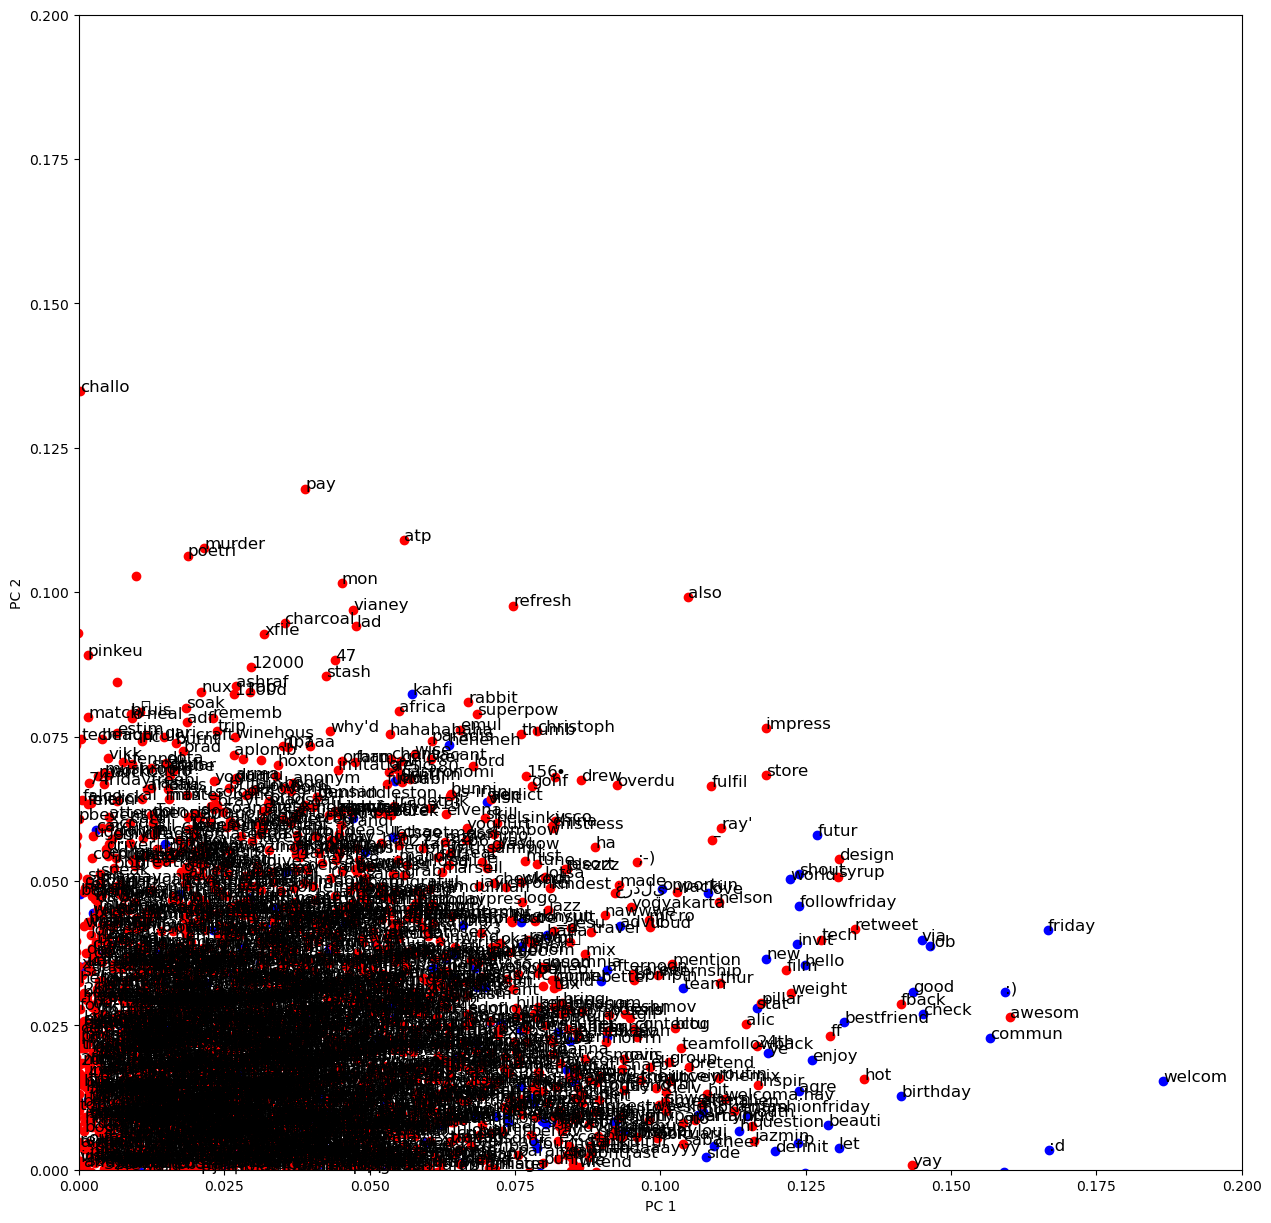

In [44]:
# visualize the word embeddings 

# Get weights from the embedding layer
weights = classifier_model.layers[0].get_weights()[0]

# Get the token vectors
token_vectors = weights

# visualize the word embeddings
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualize_word_embeddings(embeddings, word2idx, idx2word):
    # Fit a 2D PCA model to the embeddings
    pca = PCA(n_components=2)
    results = pca.fit_transform(embeddings)
    
    # Get the figure
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111)
    
    # Plot the words positive words in blue text
    ax.scatter(results[:500,0],results[:500,1], marker='o', color='blue')
    # anaotate the words
    for i, word in enumerate(list(word2idx.keys())[:500]):
        ax.annotate(word, xy=(results[i, 0], results[i, 1]), fontsize=12)       

    # Plot the words negative words in red
    ax.scatter(results[500:,0],results[500:,1], marker='o', color='red')
    # anaotate the words
    for i, word in enumerate(list(word2idx.keys())[500:]):
        ax.annotate(word, xy=(results[i+500, 0], results[i+500, 1]), fontsize=12)
    
    # Set x and y limits  
    ax.set_xlim(0, 0.2)  
    ax.set_ylim(0, 0.2)

    # axis labels
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")

    # Show the plot
    plt.show()

# Visualize your embeddings
visualize_word_embeddings(token_vectors, Vocab, Vocab)

